# EGAS00001004809 scRNA Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import os as os
import sys as sys
sys.path.append('/home/qiuaodon/Desktop/PanCancer_scRNA_analysis/utils/')
from scRNA_utils import *
import operator as op

## Read in data matrix and combine with meta-data of obs

In [2]:
# Read in data in H5AD format
data_dir = "/home/data/ICI_exprs/EGAS00001004809/"
data_file =  data_dir + '1863-counts_cells_cohort1.h5ad'
adata = sc.read_h5ad(data_file)
print ("Read in dataset with dimension: " + str(adata.shape))

Read in dataset with dimension: (175942, 25288)


In [3]:
# read in the csv meta-data
meta_file_pathname = data_dir + "1872-BIOKEY_metaData_cohort1_web.csv"
cohort1_meta = pd.read_csv(meta_file_pathname, header = 0, index_col = 0)

In [4]:
# make sure the index of cohort1_meta agree with the obs of adata
cohort1_meta = cohort1_meta.reindex(adata.obs.index)
adata.obs = cohort1_meta
print(adata.obs.columns)
print(adata.obs['patient_id'].unique())

Index(['nCount_RNA', 'nFeature_RNA', 'patient_id', 'timepoint', 'expansion',
       'BC_type', 'cellType', 'cohort'],
      dtype='object')
['BIOKEY_13' 'BIOKEY_10' 'BIOKEY_16' 'BIOKEY_14' 'BIOKEY_19' 'BIOKEY_23'
 'BIOKEY_26' 'BIOKEY_28' 'BIOKEY_3' 'BIOKEY_15' 'BIOKEY_8' 'BIOKEY_5'
 'BIOKEY_30' 'BIOKEY_12' 'BIOKEY_1' 'BIOKEY_31' 'BIOKEY_20' 'BIOKEY_22'
 'BIOKEY_25' 'BIOKEY_21' 'BIOKEY_29' 'BIOKEY_4' 'BIOKEY_9' 'BIOKEY_18'
 'BIOKEY_11' 'BIOKEY_7' 'BIOKEY_2' 'BIOKEY_6' 'BIOKEY_17' 'BIOKEY_27'
 'BIOKEY_24']


In [5]:
adata.obs['expansion'].unique()

array([nan, 'E', 'NE'], dtype=object)

In [6]:
# change "timepoint" values to lowercase
adata.obs["timepoint"] = adata.obs["timepoint"].str.lower()
adata.obs["timepoint"].unique()

array(['pre', 'on'], dtype=object)

In [7]:
# the field "cohort" is equivalent to "treatment", rename it
adata.obs.rename(columns={'cohort': 'treatment'}, inplace=True)

In [8]:
# extract sample_id from index, re-join first three columns of index after splitting by "_"
adata.obs['sample_id'] = adata.obs.index.str.split("_").str[0:3].str.join("_")

In [9]:
adata.obs.sample_id.head()

BIOKEY_13_Pre_AAACCTGCAACAACCT-1    BIOKEY_13_Pre
BIOKEY_13_Pre_AAACCTGCAAGAAGAG-1    BIOKEY_13_Pre
BIOKEY_13_Pre_AAACCTGGTCTCCACT-1    BIOKEY_13_Pre
BIOKEY_13_Pre_AAACCTGTCAACGAAA-1    BIOKEY_13_Pre
BIOKEY_13_Pre_AAACGGGAGAGTAAGG-1    BIOKEY_13_Pre
Name: sample_id, dtype: object

In [9]:
adata.var

Empty DataFrame
Columns: []
Index: [A1BG, A1BG-AS1, A2M, A2M-AS1, A4GALT, AAAS, AACS, AADAC, AADACL2-AS1, AADAT, AAED1, AAGAB, AAK1, AAMDC, AAMP, AAR2, AARD, AARS, AARS2, AARSD1, AASDH, AASDHPPT, AASS, AATF, ABALON, ABAT, ABCA1, ABCA10, ABCA2, ABCA3, ABCA5, ABCA6, ABCA7, ABCA8, ABCA9, ABCB1, ABCB10, ABCB4, ABCB5, ABCB6, ABCB7, ABCB8, ABCB9, ABCC1, ABCC10, ABCC11, ABCC3, ABCC4, ABCC5, ABCC6, ABCC9, ABCD1, ABCD2, ABCD3, ABCD4, ABCE1, ABCF1, ABCF2, ABCF3, ABCG1, ABCG2, ABHD1, ABHD10, ABHD11, ABHD12, ABHD13, ABHD14A, ABHD14A-ACY1, ABHD14B, ABHD15, ABHD16A, ABHD17A, ABHD17B, ABHD17C, ABHD18, ABHD2, ABHD3, ABHD4, ABHD5, ABHD6, ABHD8, ABI1, ABI2, ABI3, ABI3BP, ABL1, ABL2, ABLIM1, ABLIM2, ABLIM3, ABO, ABR, ABRACL, ABRAXAS1, ABRAXAS2, ABT1, ABTB1, ABTB2, AC000403.1, AC002070.1, ...]

[25288 rows x 0 columns]

### Extract tissue type from the sample name or from meta-data

In [10]:
# drop the nCount_RNA and nFeature_RNA columns
adata.obs.drop(columns=['nCount_RNA', 'nFeature_RNA'], inplace=True)

# rearrange the columns order: "patient_id", "sample_id", "timepoint", "treatment", "cell_type"
adata.obs = adata.obs[["patient_id", "sample_id", "timepoint", "treatment", 'expansion', 'BC_type', 'cellType']]   

In [11]:
print(adata.obs.columns)

Index(['patient_id', 'sample_id', 'timepoint', 'treatment', 'expansion',
       'BC_type', 'cellType'],
      dtype='object')


## Basic Filtering

In [12]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.9.2 umap==0.5.4 numpy==1.26.4 scipy==1.13.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [13]:
# removing cells expressing <500 || >5000 genes
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes=5000)

filtered out 32633 cells that have less than 500 genes expressed


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['n_genes'] = number


filtered out 5971 cells that have more than 5000 genes expressed


In [14]:
print ('Dimention of adata: ' + str(adata.shape))
print ('columns for adata.obs: ' + str(adata.obs.columns))

Dimention of adata: (137338, 25288)
columns for adata.obs: Index(['patient_id', 'sample_id', 'timepoint', 'treatment', 'expansion',
       'BC_type', 'cellType', 'n_genes'],
      dtype='object')


In [15]:
# removing cells containing <400 || >25000 UMIs
sc.pp.filter_cells(adata, min_counts = 400)
sc.pp.filter_cells(adata, max_counts = 25000)

filtered out 2586 cells that have more than 25000 counts


In [16]:
print ('Dimention of adata: ' + str(adata.shape))
print ('columns for adata.obs: ' + str(adata.obs.columns))

Dimention of adata: (134752, 25288)
columns for adata.obs: Index(['patient_id', 'sample_id', 'timepoint', 'treatment', 'expansion',
       'BC_type', 'cellType', 'n_genes', 'n_counts'],
      dtype='object')


## process the var

### Removing genes covered by <10 cells per sample

In [17]:
# removing genes covered by <10 cells
sc.pp.filter_genes(adata, min_cells= 10)
adata.var_names_make_unique()
adata.shape

filtered out 2319 genes that are detected in less than 10 cells


(134752, 22969)

### Remove cells with high percentage of mitochondrial genes

In [18]:
# label genes as mt
adata.var['mt'] = adata.var_names.str.startswith('MT-')  

# annotate cells with the percent of genes assigned as mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# remove mitochondrial genes from analysis
adata = adata[:, ~adata.var['mt'].values]

# Here we keep cells with < 20% mito ratio
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
adata.shape

(134752, 22956)

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


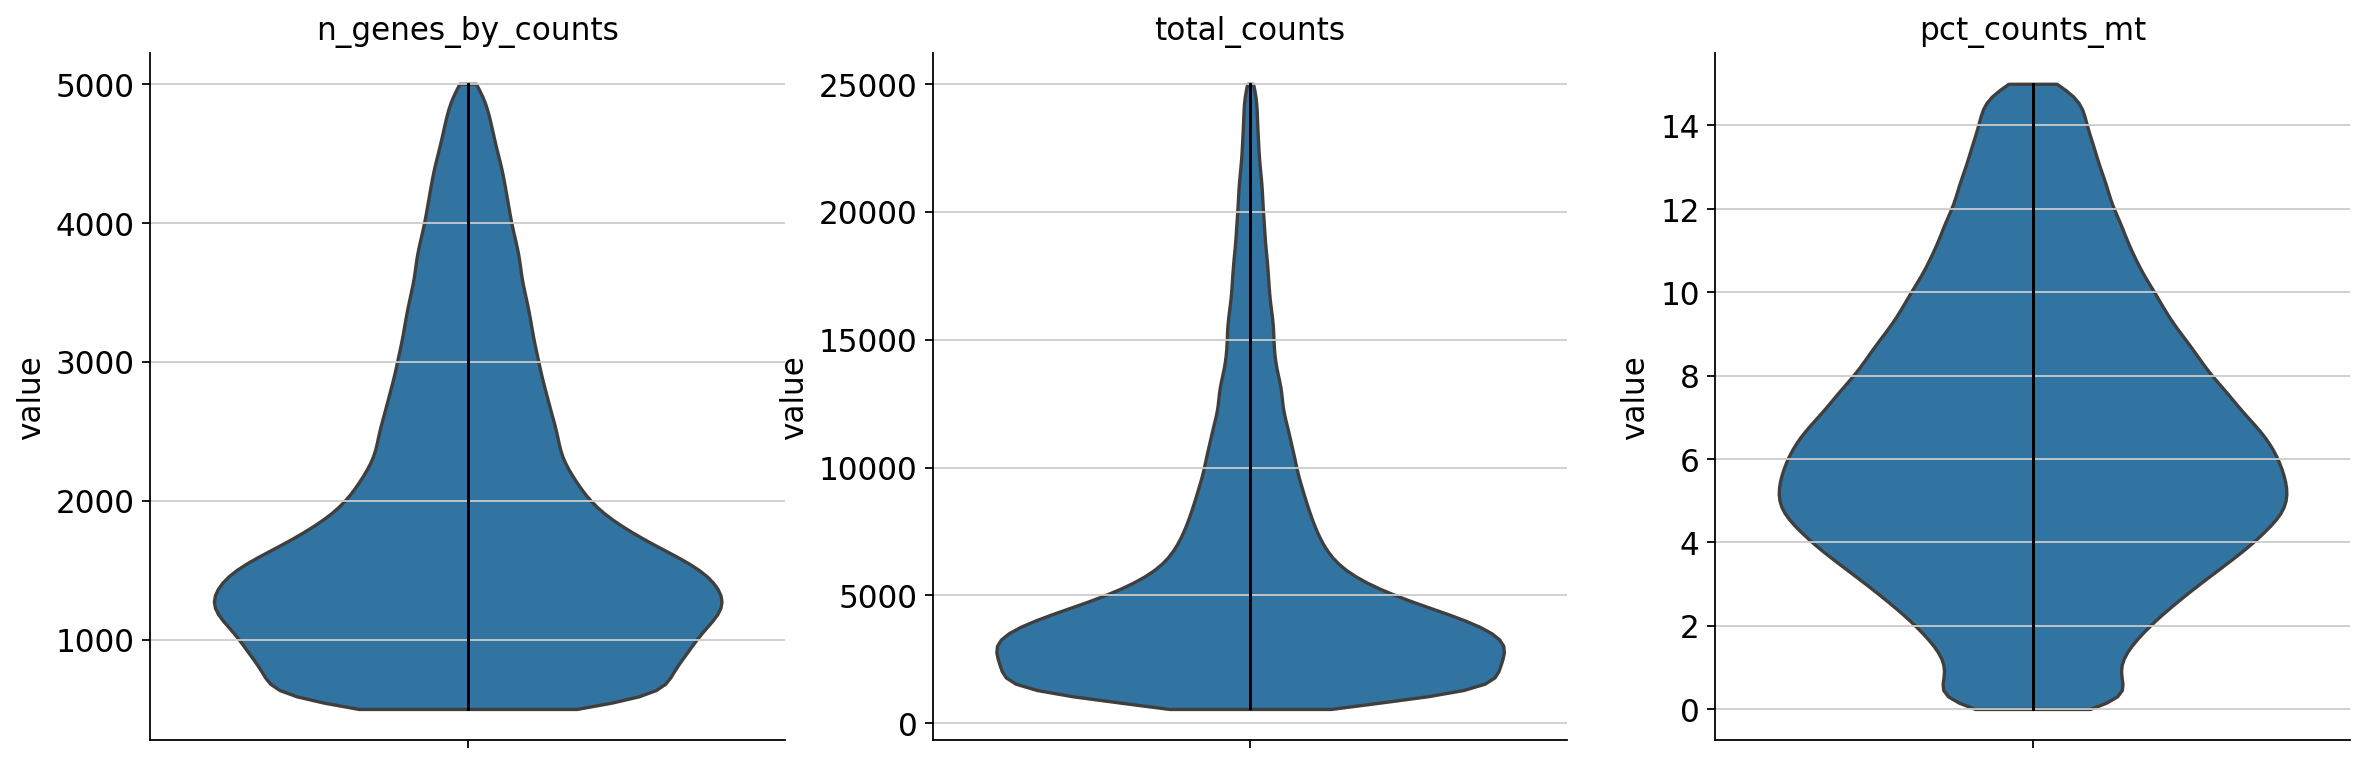

In [19]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.0, multi_panel=True)

## Integrating Samples

### Normalization & Logarithmization:

In [20]:
# Log normalization scaled up to 10000
print('Before normalization, the sum of first row of X: ' + str(adata.X[0,:].sum()))
sc.pp.normalize_total(adata, target_sum=1e4)
print('After normalization, the sum of first row of X: ' + str(adata.X[0,:].sum()))


Before normalization, the sum of first row of X: 1201.0
normalizing counts per cell
    finished (0:00:01)
After normalization, the sum of first row of X: 9999.931


In [21]:
print('Before log, the sum of first row of X: ' + str(adata.X[0,:].sum()))
# Logarithmize adata
sc.pp.log1p(adata, base = 2)
print('After log, the sum of first row of X: ' + str(adata.X[0,:].sum()))

Before log, the sum of first row of X: 9999.931
After log, the sum of first row of X: 2464.4731


### keep high variance genes

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


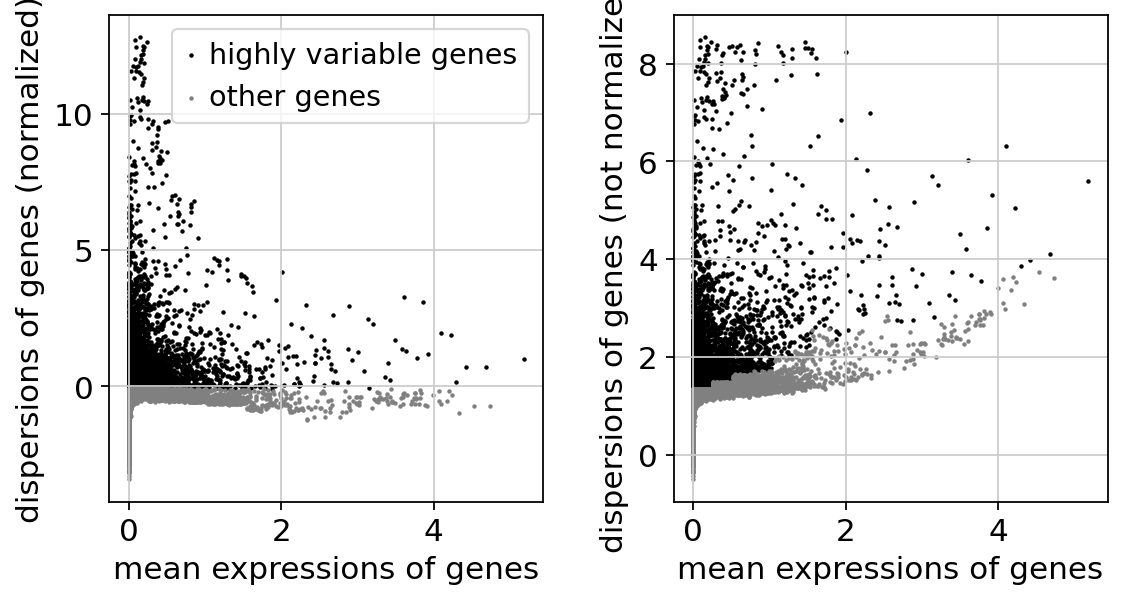

In [19]:
n_top_genes=10000
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
sc.pl.highly_variable_genes(adata)

In [22]:
adata.var.columns

Index(['n_cells', 'mt', 'n_cells_by_counts', 'mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm'],
      dtype='object')

### Keep track of original adata and update adata.X to  high variance genes only

In [20]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
print('adata dimensions of high variance genes: ' + str(adata.shape))

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


adata dimensions of high variance genes: (134752, 10000)


## Unsupervised cell clustering & identification of major cell types

In [21]:
# perform PCA   
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:26)


In [25]:
print(adata.obsm['X_pca'].shape)
print(adata.varm['PCs'].shape)
print(adata.uns['pca']['variance_ratio'].shape)
print(adata.obs.columns)

(134752, 30)
(10000, 30)
(30,)
Index(['patient_id', 'sample_id', 'timepoint', 'treatment', 'expansion',
       'BC_type', 'cellType', 'n_genes', 'n_counts', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt'],
      dtype='object')


In [22]:
sc.pp.neighbors(adata, n_neighbors=80, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:28)


In [23]:
# Use the Leiden algorithm to find clusters
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:07:35)


ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:10)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is high

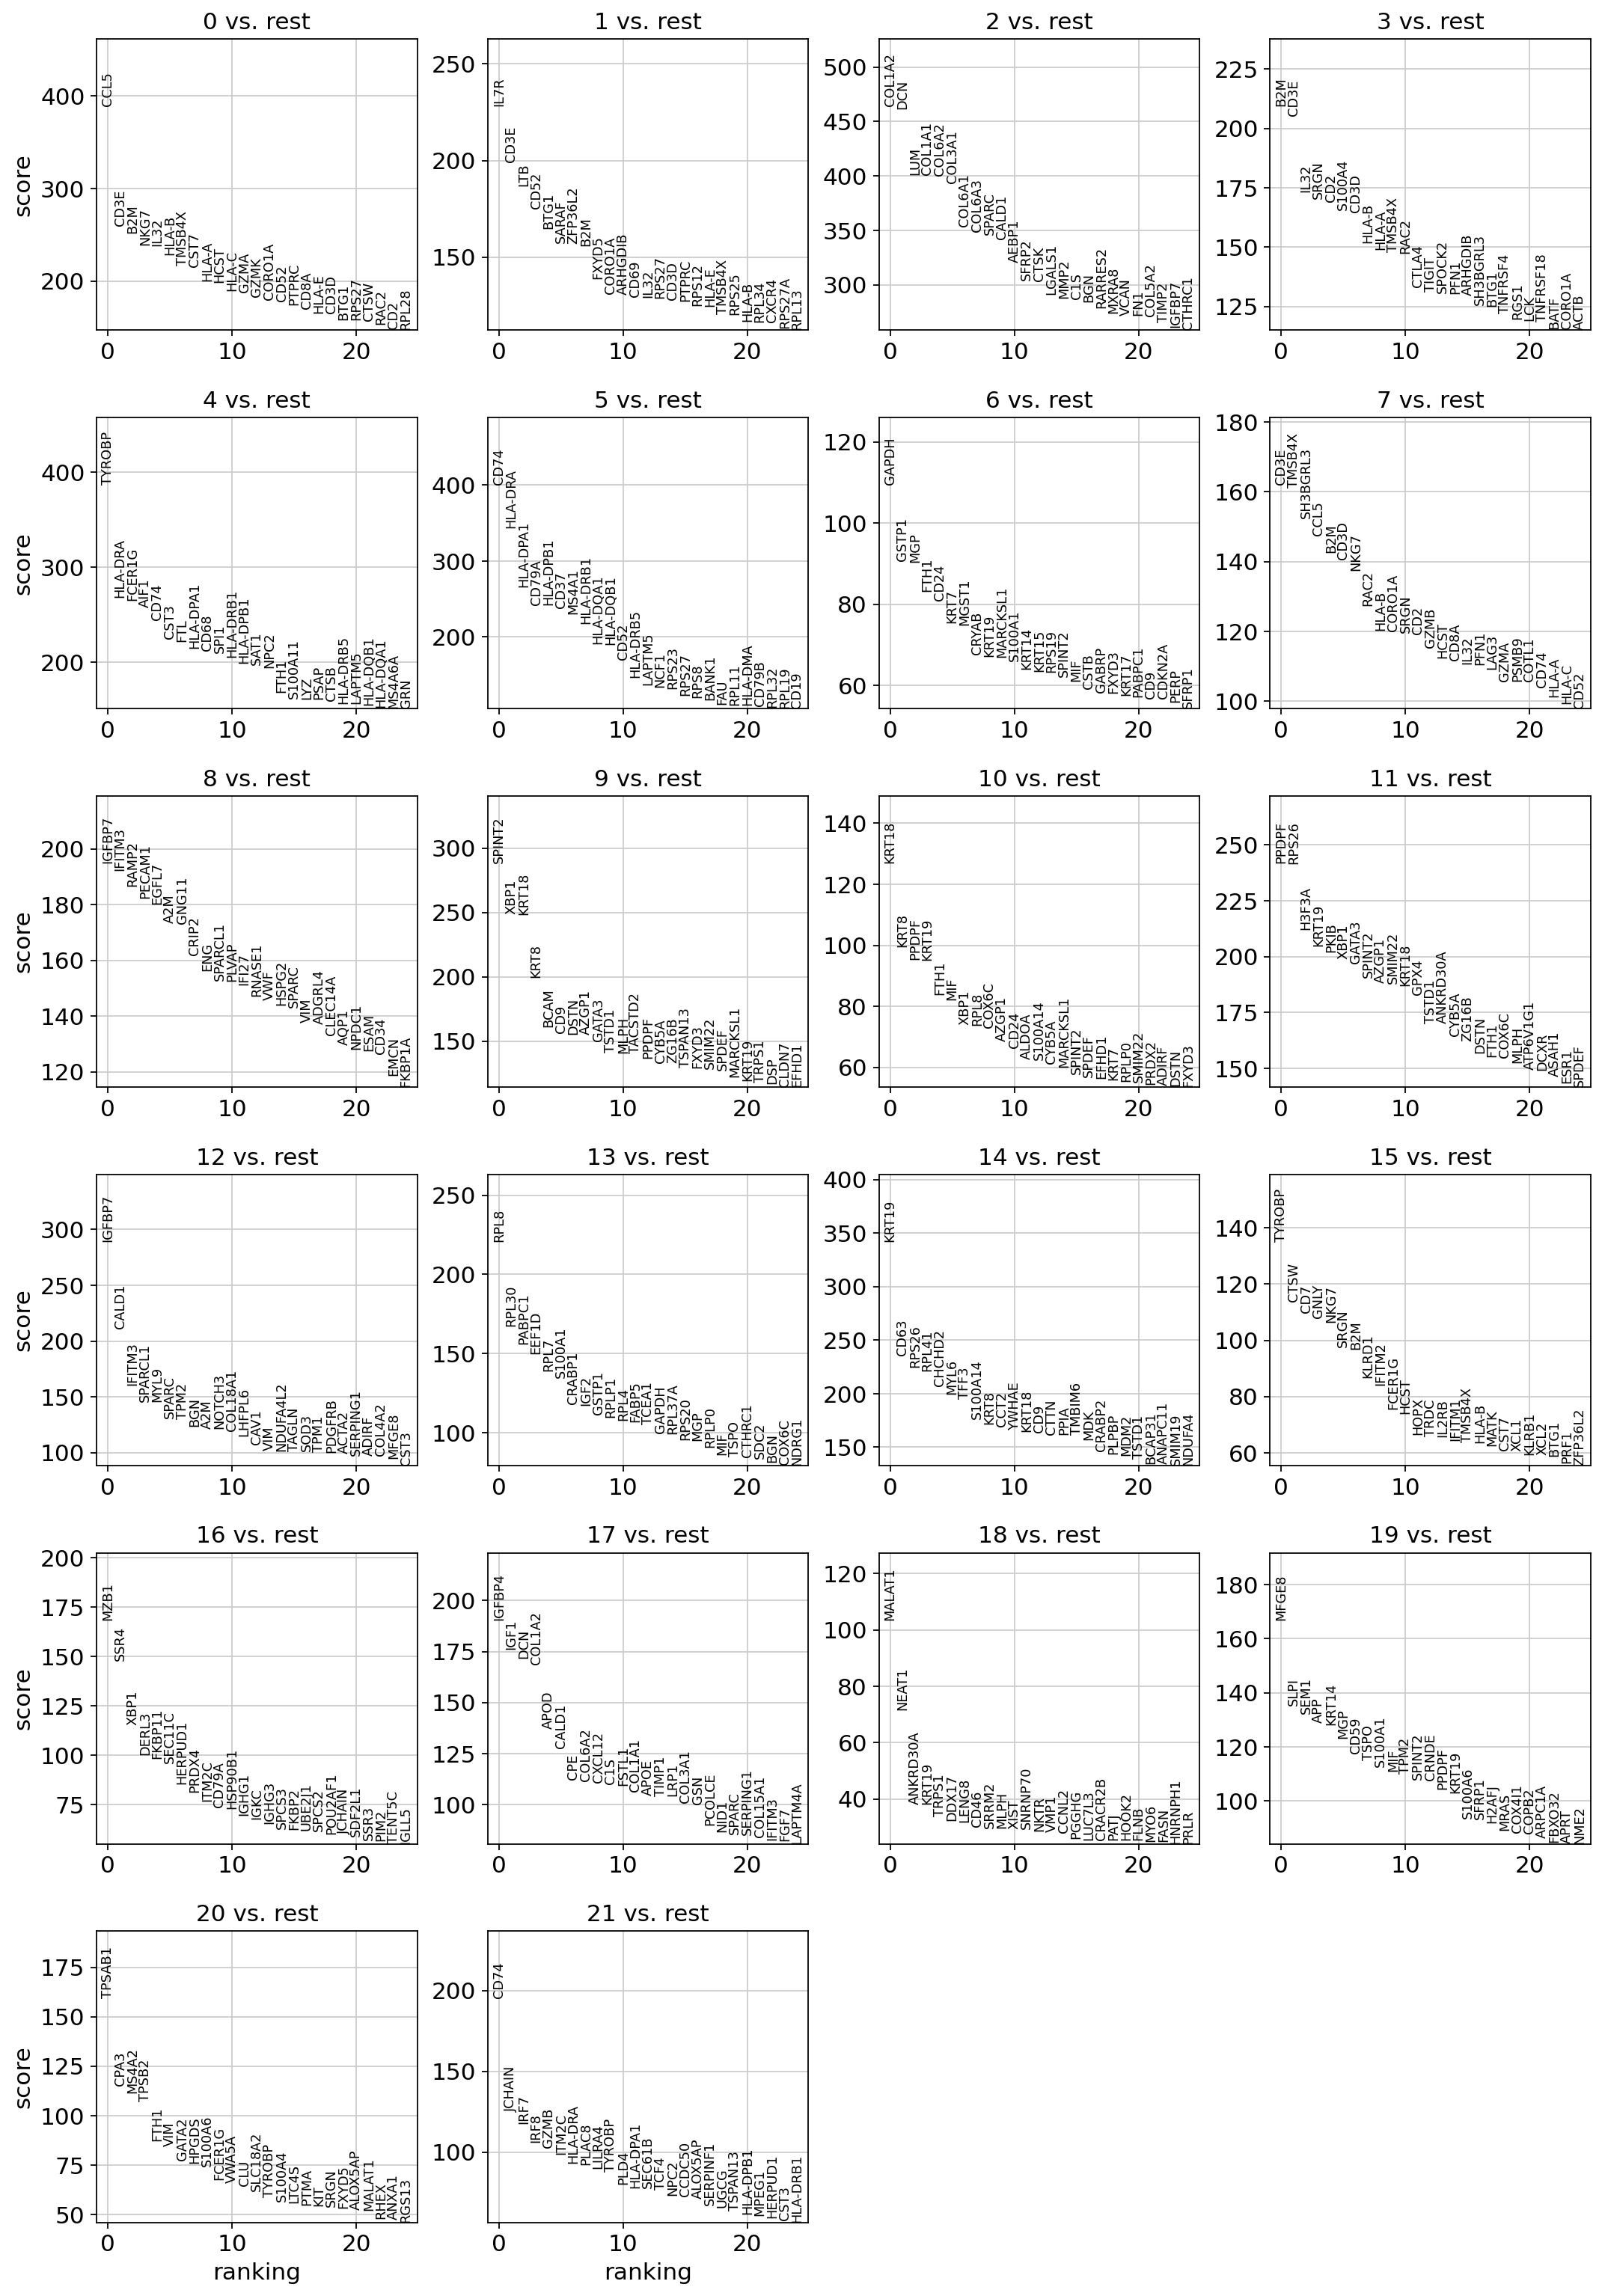

In [24]:
# load/find cell cycle markers: T-test/T-cells
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:03)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


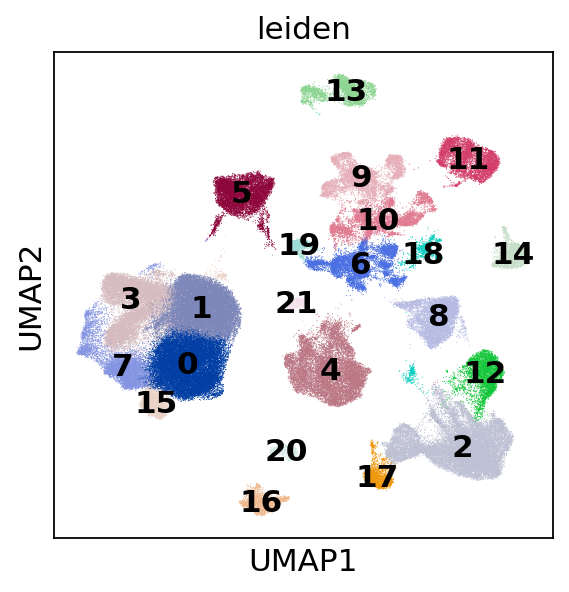

In [29]:
# perform UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden',legend_loc='on data')

### Label cells based on cell markers

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: T cells, B cells, Myeloid, etc.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curren

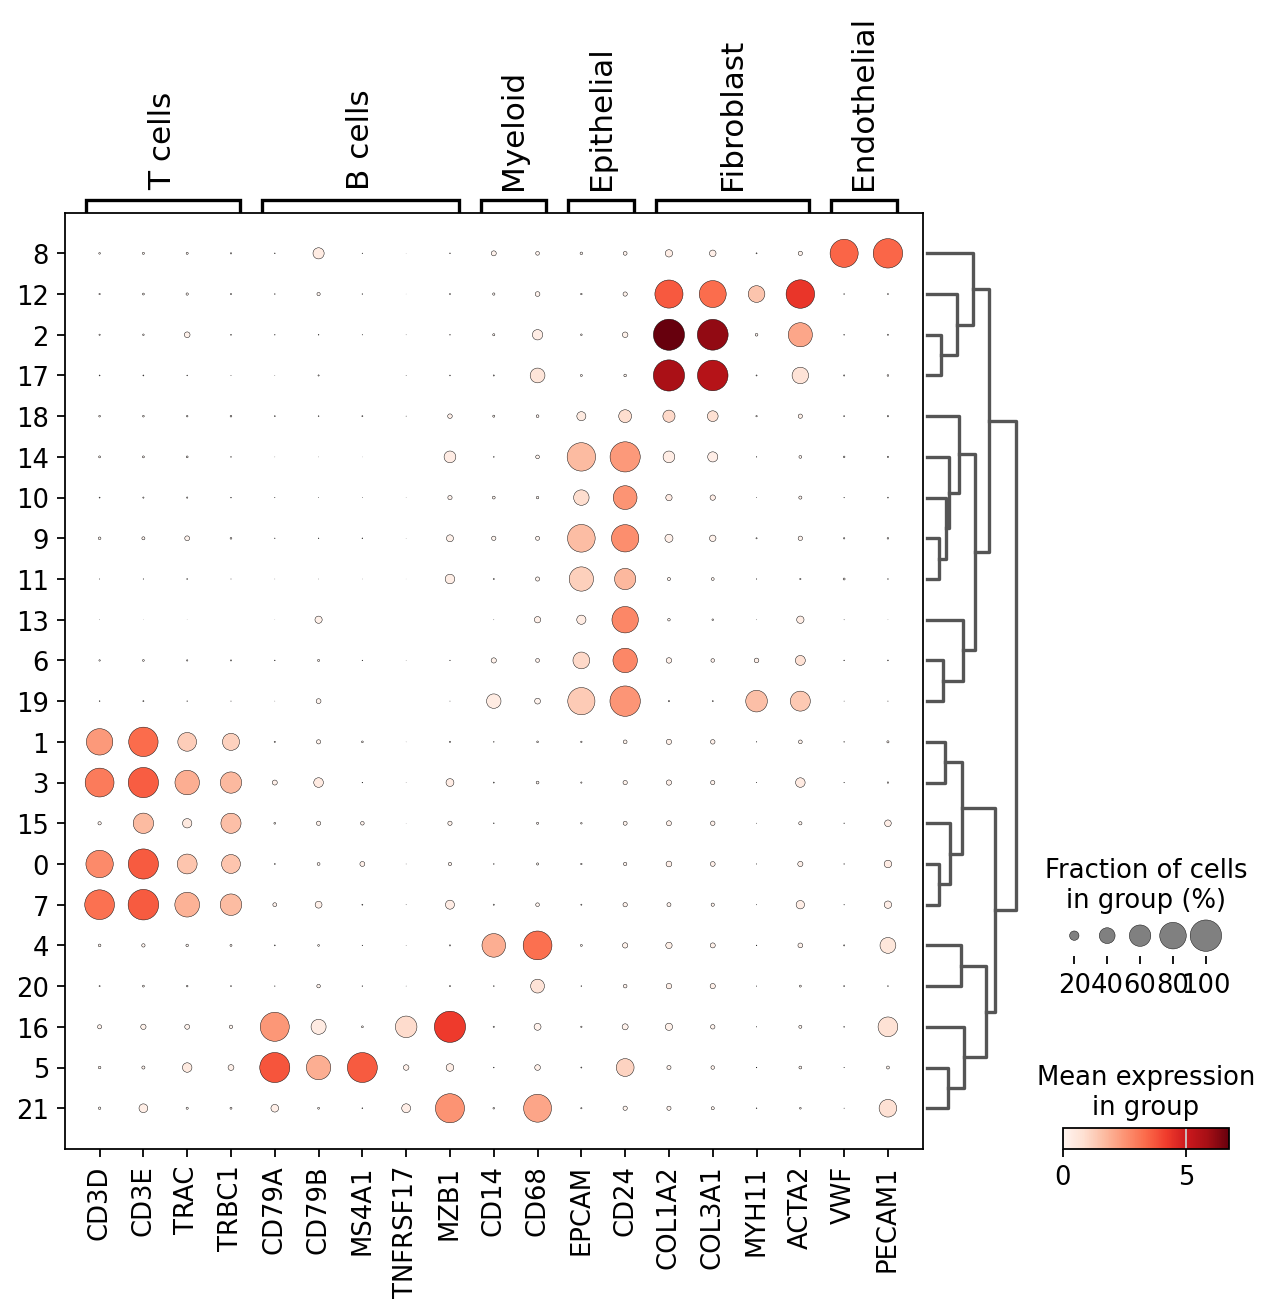

In [30]:
cell_type_markers = {
    'T cells': ['CD3D', 'CD3E', 'TRAC', 'TRBC1'],
    'B cells': ['CD79A', 'CD79B', 'MS4A1', 'TNFRSF17', 'MZB1'],
    'Myeloid': ['CD14', 'CD68'],
    'Epithelial': ['EPCAM', 'CD24'],
    'Fibroblast': ['COL1A2', 'COL3A1', 'MYH11', 'ACTA2'],
    'Endothelial': ['VWF', 'PECAM1']
}
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.dotplot(adata, cell_type_markers, 'leiden', dendrogram=True)

Cluster 0 is most likely T cells with 0.7059756957630337 overlap
Cluster 4 is most likely Myeloid with 0.7852661684657256 overlap
Cluster 12 is most likely Fibroblast with 0.7454596255937412 overlap
Cluster 2 is most likely Fibroblast with 0.674745417515275 overlap
Cluster 8 is most likely Endothelial with 0.8880092510229497 overlap
Cluster 15 is most likely T cells with 0.33990944372574383 overlap
Cluster 1 is most likely T cells with 0.6629242669129531 overlap
Cluster 16 is most likely B cells with 0.5778238341968912 overlap
Cluster 5 is most likely B cells with 0.5678307779670642 overlap
Cluster 3 is most likely T cells with 0.7875804375804376 overlap
Cluster 7 is most likely T cells with 0.8046279786026909 overlap
Cluster 9 is most likely Epithelial with 0.8357650921028634 overlap
Cluster 6 is most likely Epithelial with 0.5732148474363007 overlap
Cluster 20 is most likely Myeloid with 0.17149758454106281 overlap
Cluster 21 is most likely Myeloid with 0.43591549295774645 overlap
Cl

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


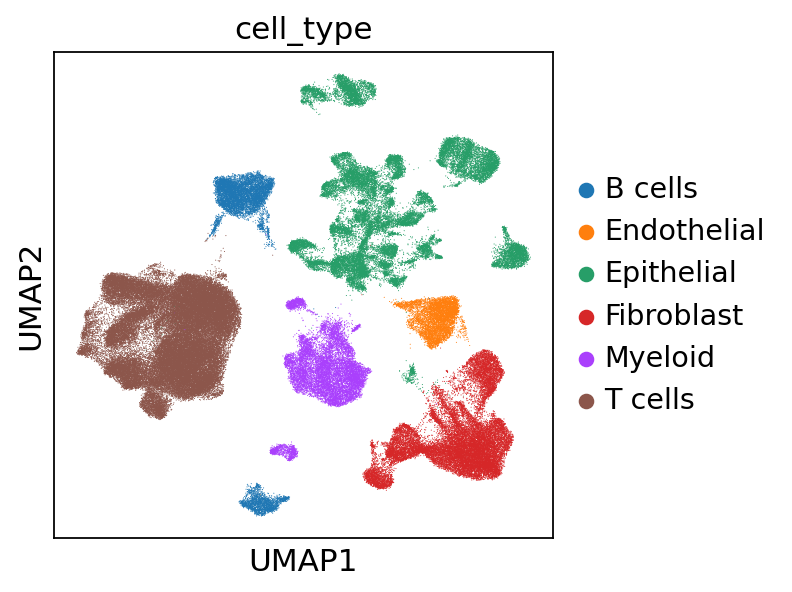

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


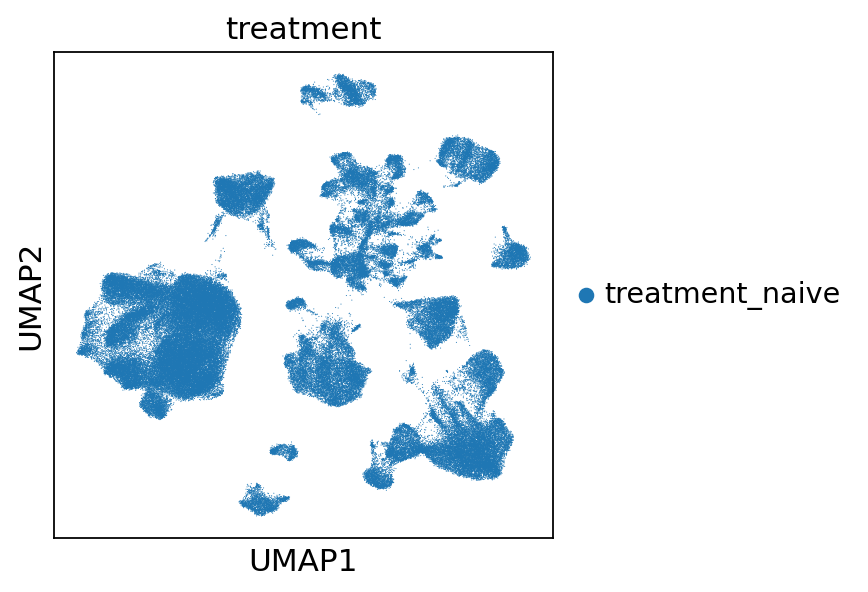

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


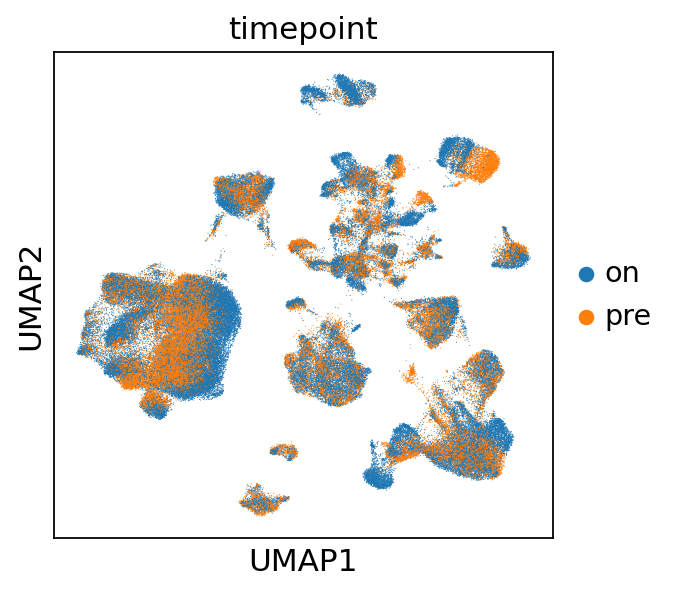

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


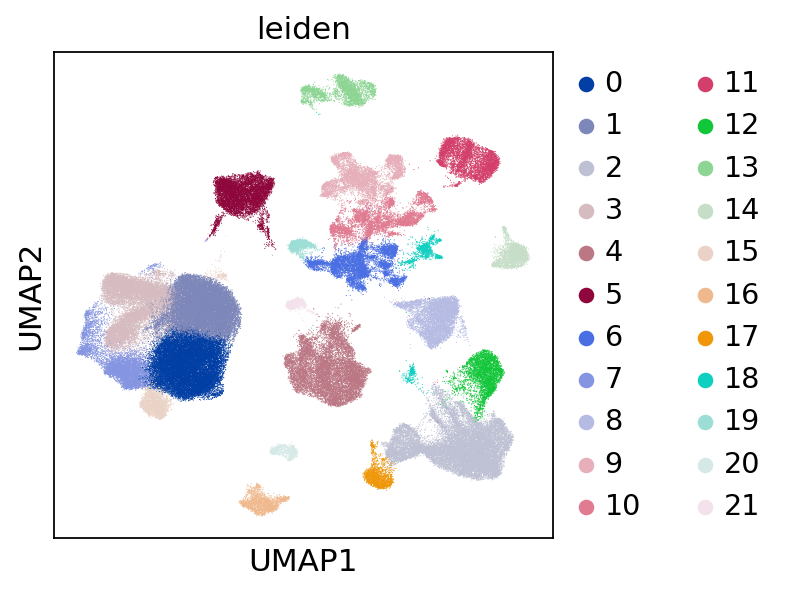

In [31]:
labelClusterWithCellType(adata, cell_type_markers)
sc.pl.umap(adata, color=['cell_type'])
sc.pl.umap(adata, color=['treatment'])
sc.pl.umap(adata, color=['timepoint'])
sc.pl.umap(adata, color=['leiden'])

In [32]:
#save the adata object
adata.write('/home/qiuaodon/Desktop/project_data_new/whole_cohort1_processed.h5ad')

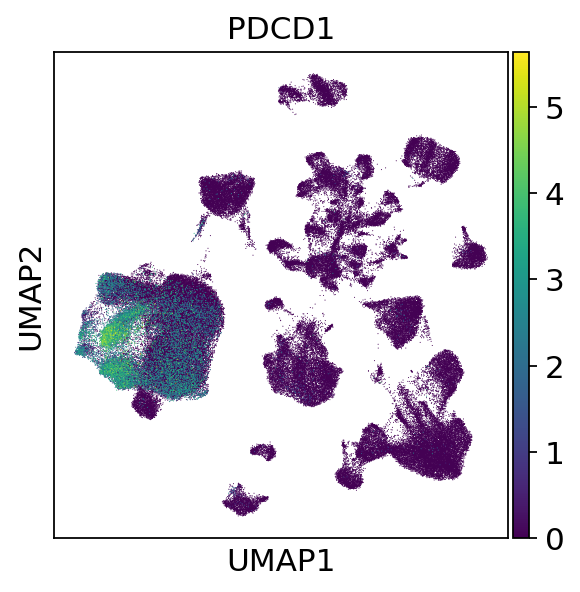

In [47]:
# show the UMAP of PDCD1 with a valid color_map
sc.pl.umap(adata, color='PDCD1', color_map='viridis')


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


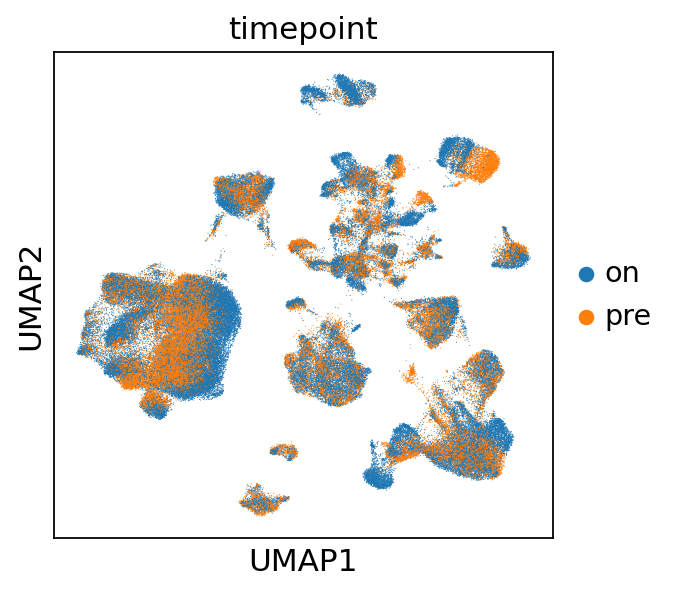

In [51]:
sc.pl.umap(adata, color='timepoint')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


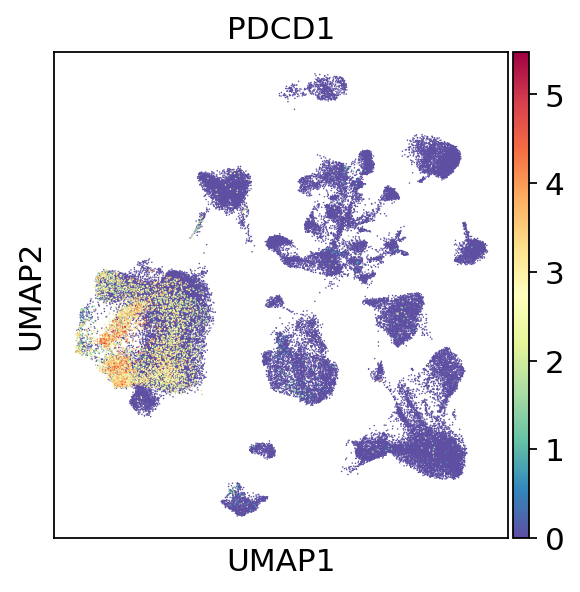

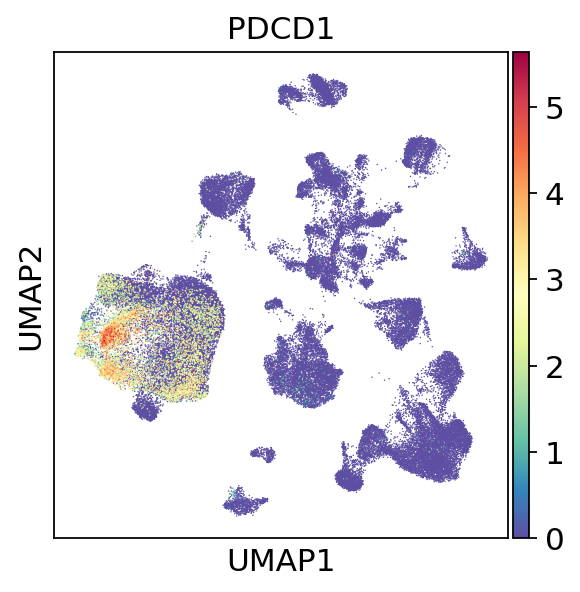

In [105]:
# select the cells from the timepoint pre
adata_pre = adata[adata.obs['timepoint'] == 'pre', :]
sc.pl.umap(adata_pre, color='PDCD1', color_map='Spectral_r')
adata_on = adata[adata.obs['timepoint'] == 'on', :]
sc.pl.umap(adata_on, color='PDCD1', color_map='Spectral_r')

## Some statistics of cell distribution pre and post treatment

/tmp/ipykernel_2091038/3304470680.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_count = adata.obs.groupby('cell_type').size()


Text(0.5, 1.0, 'Overall cell type distribution')

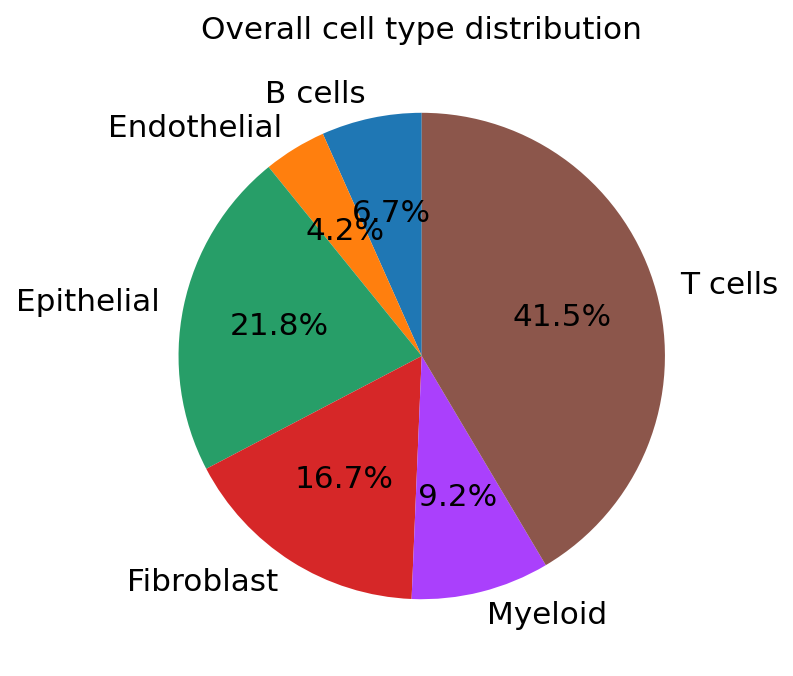

In [ ]:
# count the number of cells in each cell type
cell_type_count = adata.obs.groupby('cell_type').size()
# plot a pie chart
cell_type_count.plot.pie(y='cell_type', figsize=(5, 5), autopct='%1.1f%%', startangle=90)
plt.title('Overall cell type distribution')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


/tmp/ipykernel_2091038/1607192351.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_count_pre = adata_pre.obs.groupby(['cell_type']).size()


Text(0.5, 1.0, 'Cell type distribution in pre')

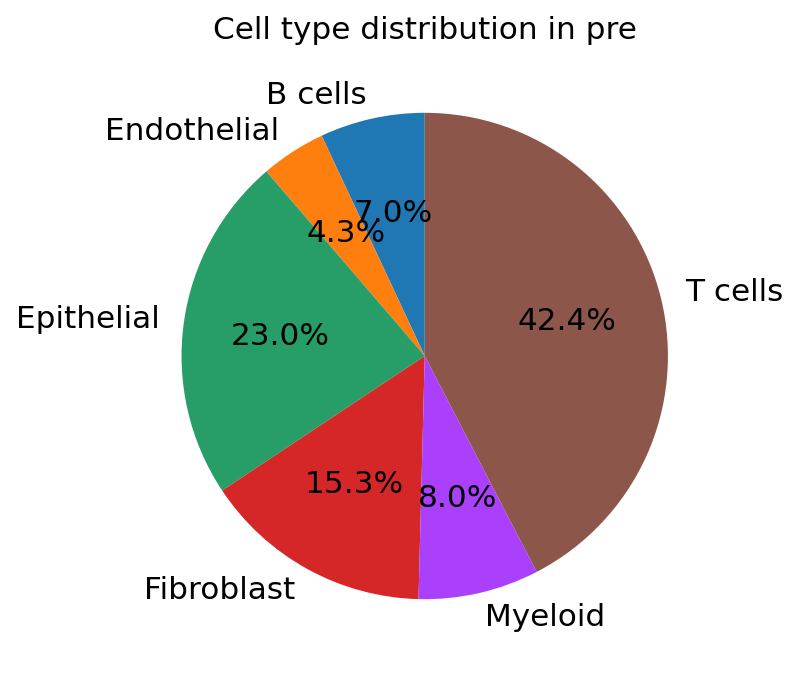

In [ ]:
# count the number of cells in each cell type in pre and on 
adata_pre = adata[adata.obs['timepoint'] == 'pre', :]
cell_type_count_pre = adata_pre.obs.groupby(['cell_type']).size()
cell_type_count_pre.plot.pie(y='cell_type', figsize=(5, 5), autopct='%1.1f%%', startangle=90)
plt.title('Cell type distribution in pre')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_2091038/204781595.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_count_on = adata_on.obs.groupby(['cell_type']).size()


Text(0.5, 1.0, 'Cell type distribution in on')

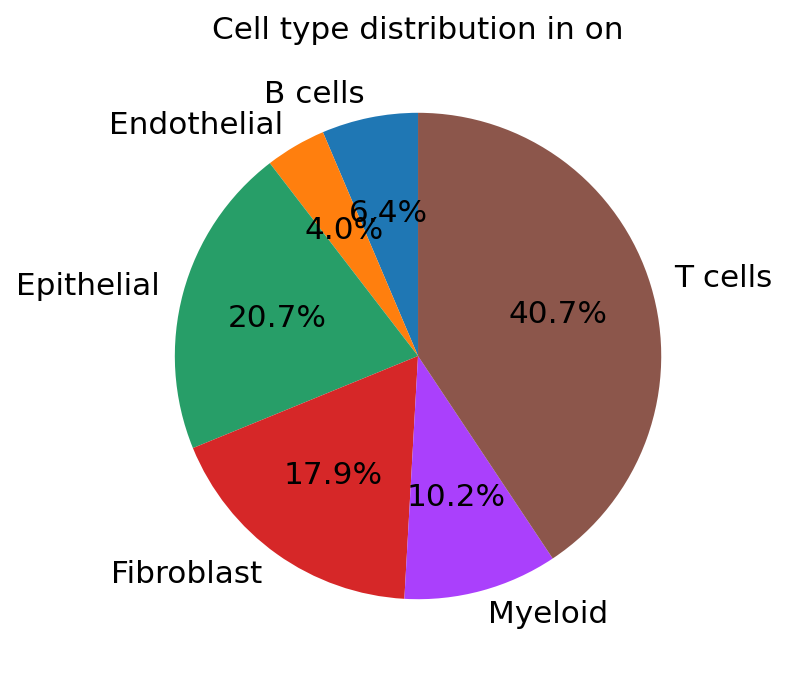

In [ ]:
# count the number of cells in each cell type in pre and on 
adata_on = adata[adata.obs['timepoint'] == 'on', :]
cell_type_count_on = adata_on.obs.groupby(['cell_type']).size()
cell_type_count_on.plot.pie(y='cell_type', figsize=(5, 5), autopct='%1.1f%%', startangle=90)
plt.title('Cell type distribution in on')


## Extract T cells, cluster and create a new AnnData object

### use the raw data of T cells to get the clusters

In [108]:
# restore the X to original raw.X for re-processing 
adata.raw = adata
adata_T = adata[adata.obs['cell_type'] == 'T cells', :]
adata_T  = ad.AnnData(X=adata_T.raw.X, obs=adata_T.obs, var=adata_T.raw.var)
adata_T.raw = adata_T
print(str(adata_T.shape))

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(55900, 10000)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:20)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


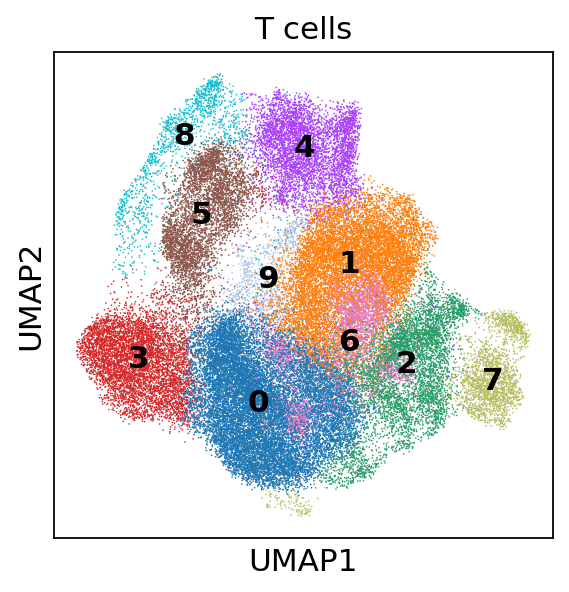

In [109]:
# reclustering T cells
# select high variance genes
n_top_gene_T = 5000
sc.pp.highly_variable_genes(adata_T, n_top_genes=n_top_gene_T)  
# filter genes
adata_T = adata_T[:, adata_T.var['highly_variable']]
# PCA
sc.pp.pca(adata_T, n_comps=50, use_highly_variable=True, svd_solver='arpack')
# UMAP
sc.pp.neighbors(adata_T, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_T)
# clustering
sc.tl.leiden(adata_T, resolution=0.5)
# plot
sc.pl.umap(adata_T, color=['leiden'], legend_loc='on data', title='T cells')


In [57]:
adata_T.var

n_cells     mt  n_cells_by_counts  mean_counts  \
A2M            27225  False              27225     1.316559   
A2M-AS1         1740  False               1740     0.013402   
A4GALT         11893  False              11893     0.127004   
AADACL2-AS1     4211  False               4211     0.057558   
AASDH           9309  False               9309     0.075197   
...              ...    ...                ...          ...   
AC005670.2        82  False                 82     0.000609   
AC139099.3       106  False                106     0.000794   
AL590560.1       137  False                137     0.001039   
OR3A2             35  False                 35     0.000267   
C20orf85          12  False                 12     0.001291   

             pct_dropout_by_counts  total_counts  highly_variable     means  \
A2M                      79.796218      177409.0             True  0.095735   
A2M-AS1                  98.708739        1806.0             True  0.050819   
A4GALT                   91.174157       17114.0             True  0.009417   
AADACL2-AS1              96.875000        7756.0             True  0.000400   
AASDH                    93.091754       10133.0             True  0.137418   
...                            ...           ...              ...       ...   
AC005670.2               99.939147          82.0             True  0.002180   
AC139099.3               99.921337         107.0             True  0.000534   
AL590560.1               99.898332         140.0             True  0.000822   
OR3A2                    99.974026          36.0             True  0.001081   
C20orf85                 99.991095         174.0             True  0.000129   

             dispersions  dispersions_norm  
A2M             1.915135          1.039980  
A2M-AS1         1.855611          0.899361  
A4GALT          1.560144          0.201347  
AADACL2-AS1     1.659921          0.437060  
AASDH           1.557915          0.196082  
...                  ...               ...  
AC005670.2      1.667520          0.455012  
AC139099.3      1.875740          0.946914  
AL590560.1      1.621930          0.347312  
OR3A2           1.669848          0.460513  
C20orf85        1.563795          0.209971  

[5000 rows x 10 columns]

## Extract Myeloid and recluster

In [58]:
# Extract myeloid cells and create a new AnnData object
adata_M = adata[adata.obs['cell_type'] == 'Myeloid'].copy()
# restore the X to original raw.X for re-processing 
adata_M  = ad.AnnData(X=adata_M.raw.X, obs=adata_M.obs, var=adata_M.raw.var, obsm=adata_M.obsm, uns=adata_M.uns)
# drop the highly variable column in the var dataframe
adata_M.var.drop(['highly_variable'], axis=1, inplace=True)
adata_M.raw = adata_M
adata_M.shape

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(12378, 22956)

In [59]:
n_top_genes = 5000
adata_M = clustering_adata(adata_M, n_top_genes = n_top_genes)

Select  5000  high variance genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


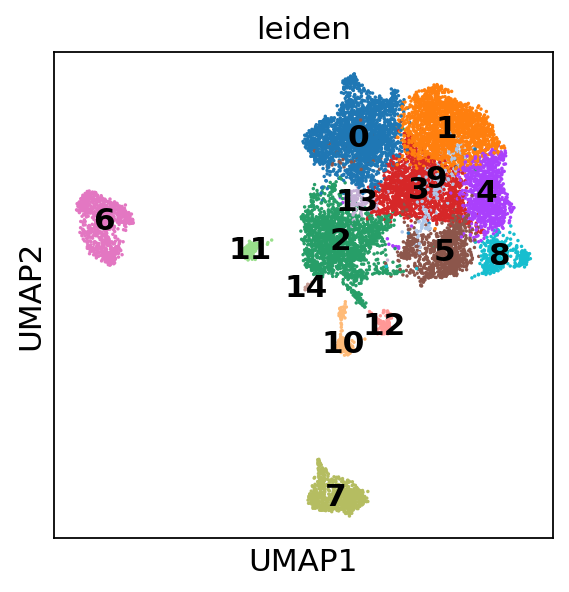

In [60]:
# plot umap
sc.pl.umap(adata_M, color='leiden',legend_loc='on data')

### It seems that there are some cells that are not myeloid cells?  We will remove them. Use the umap position to remove them.

In [61]:
# sort the sample according X_umap[:, 1] and return the index and value
index_umap_0, value_umap_0 = zip(*sorted(enumerate(adata_M.obsm['X_umap'][:, 0]), key=op.itemgetter(1)))  
index_umap_1, value_umap_1 = zip(*sorted(enumerate(adata_M.obsm['X_umap'][:, 1]), key=op.itemgetter(1)))

(array([ 10.,  78., 107., 122., 120.,  94.,  58.,  37.,  35.,  13.,  15.,
         10.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  11.,  41.,  40.,  23.,   9.,  18.,  40.,  28.,
         21.,  34.,  18.,  12.,  18.,  21.,  16.,  20.,  20.,  38., 139.,
        188., 231., 274., 328., 365., 331., 338., 270., 240., 252., 260.,
        281., 305., 305., 323., 338., 312., 274., 240., 244., 242., 238.,
        217., 234., 230., 285., 288., 298., 370., 352., 374., 319., 286.,
        268., 271., 236., 206., 220., 171.,  94.,  60.,  60.,  36.,  31.,
         16.]),
 array([-6.69040632, -6.44086027, -6.19131422, -5.94176817, -5.69222212,
        -5.44267607, -5.19313002, -4.94358397, -4.69403791, -4.44449186,
        -4.19494581, -3.94539976, -3.69585371, -3.44630766, -3.19676161,
        -2.94721556, -2.69766951, -2.44812346, -2.1985774 , -1.94903147,
        -1.69948542, -1.44

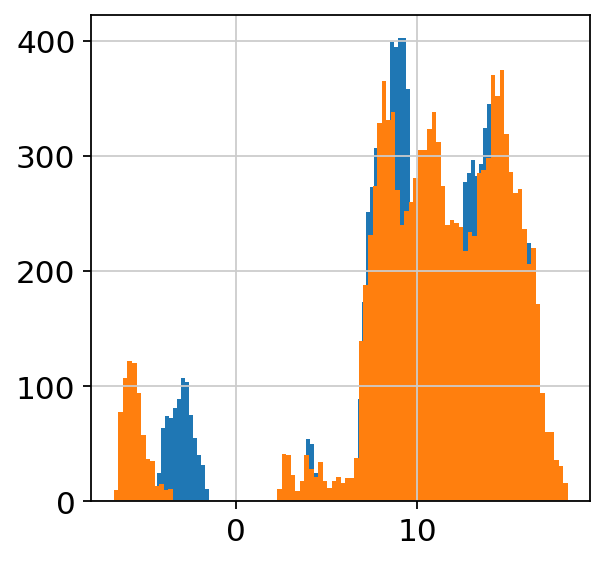

In [64]:
plt.hist(value_umap_0, bins=100)
plt.hist(value_umap_1, bins=100)

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorica

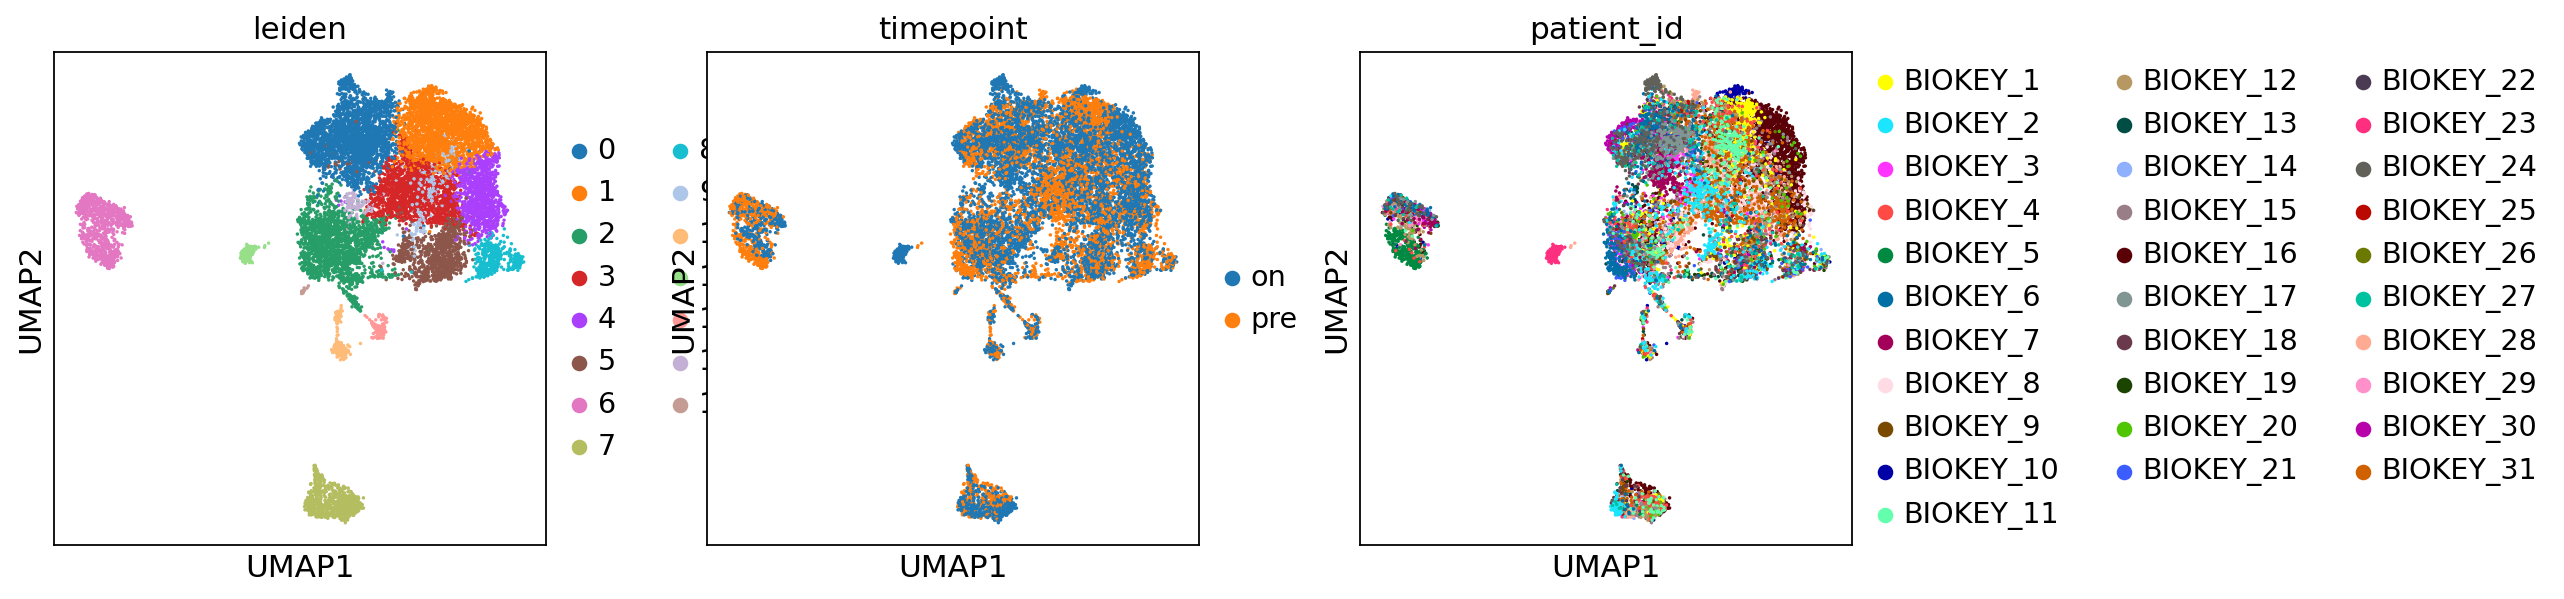

In [69]:
adata_M_clean = adata_M
sc.pl.umap(adata_M_clean, color=['leiden', 'timepoint', 'patient_id' ])

## Extract B cells and recluster

In [95]:
adata_B = adata[adata.obs['cell_type'] == 'B cells'].copy()
print(str(adata_B.shape))
# restore the X to original raw.X for re-processing 
adata_B  = ad.AnnData(X=adata_B.raw.X, obs=adata_B.obs, var=adata_B.raw.var, obsm=adata_B.obsm, uns=adata_B.uns)
# drop the highly variable gene column in the var dataframe
adata_B.var.drop(columns='highly_variable', inplace=True)
adata_B.raw = adata_B
print(str(adata_B.shape))

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(8982, 10000)
(8982, 22956)


In [66]:
n_top_genes = 5000
adata_B = clustering_adata(adata_B, resolution=0.50, n_top_genes = n_top_genes)

Select  5000  high variance genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorica

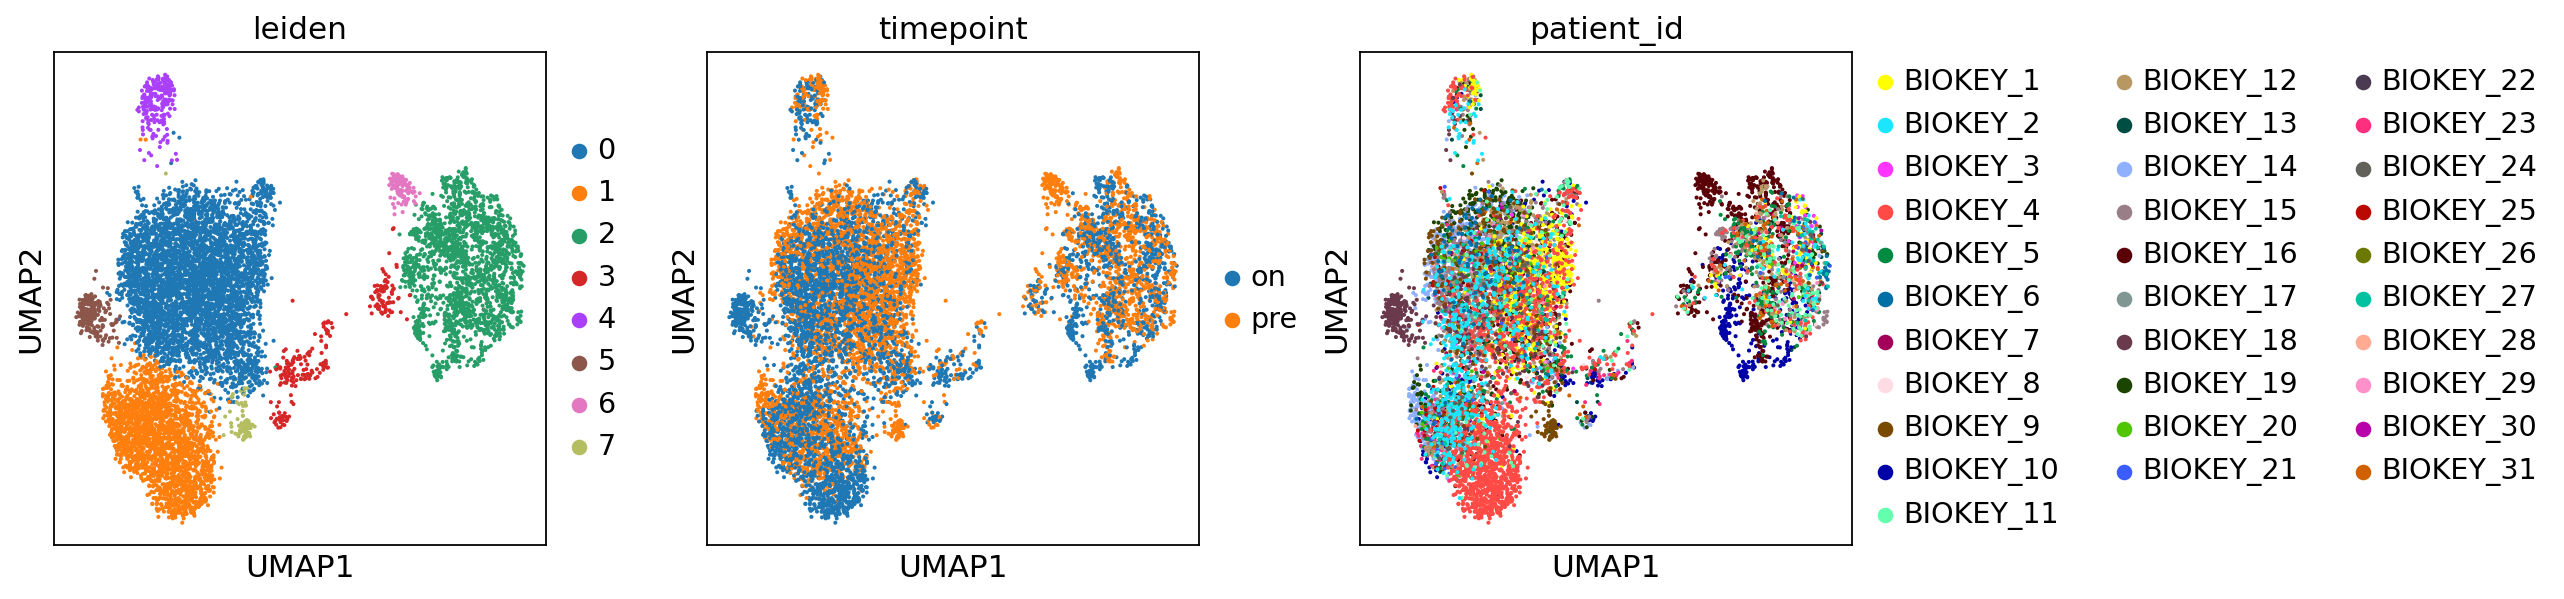

In [67]:
# plot UMAP with timepoint
sc.pl.umap(adata_B, color=['leiden', 'timepoint', 'patient_id'],show=True)

(array([ 12.,  39.,  38.,  42.,  33.,  21.,  28.,  49.,  50.,  87.,  96.,
        115., 167., 210., 214., 273., 263., 268., 295., 290., 322., 259.,
        278., 251., 249., 262., 274., 218., 224., 213., 185., 166., 160.,
        137., 152., 155., 150., 145., 138., 110., 106.,  85.,  41.,  22.,
         16.,  19.,  20.,  17.,  18.,   9.,   7.,  12.,   8.,   4.,   5.,
         18.,   9.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   3.,
          6.,  13.,  22.,  19.,  27.,  34.,  29.,  31.,  40.,  56.,  52.,
         52.,  44.,  57.,  66.,  60.,  75.,  84., 130., 126.,  86.,  96.,
         61.,  72.,  79.,  76.,  62.,  76.,  80.,  67.,  51.,  41.,  26.,
         26.]),
 array([-1.05648589, -0.87230772, -0.68812954, -0.50395143, -0.31977326,
        -0.1355951 ,  0.04858306,  0.23276122,  0.41693938,  0.60111755,
         0.78529572,  0.96947384,  1.15365207,  1.33783019,  1.5220083 ,
         1.70618653,  1.89036465,  2.07454276,  2.25872087,  2.44289923,
         2.62707734,  2.81

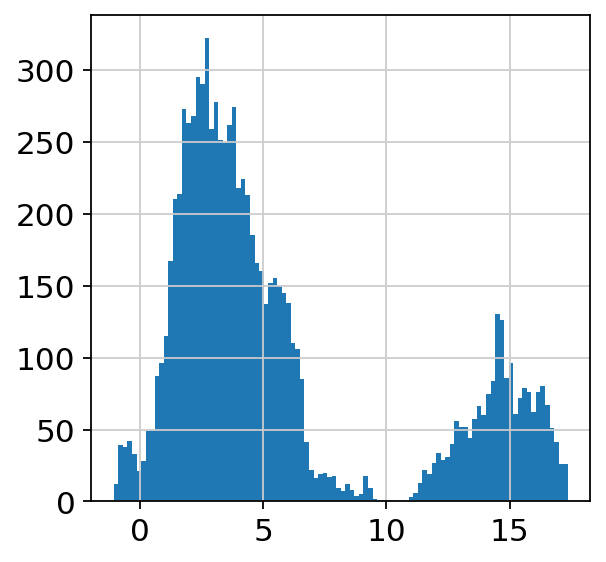

In [68]:
plt.hist(adata_B.obsm['X_umap'][:,0], bins=100)

### why we need this step

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plot

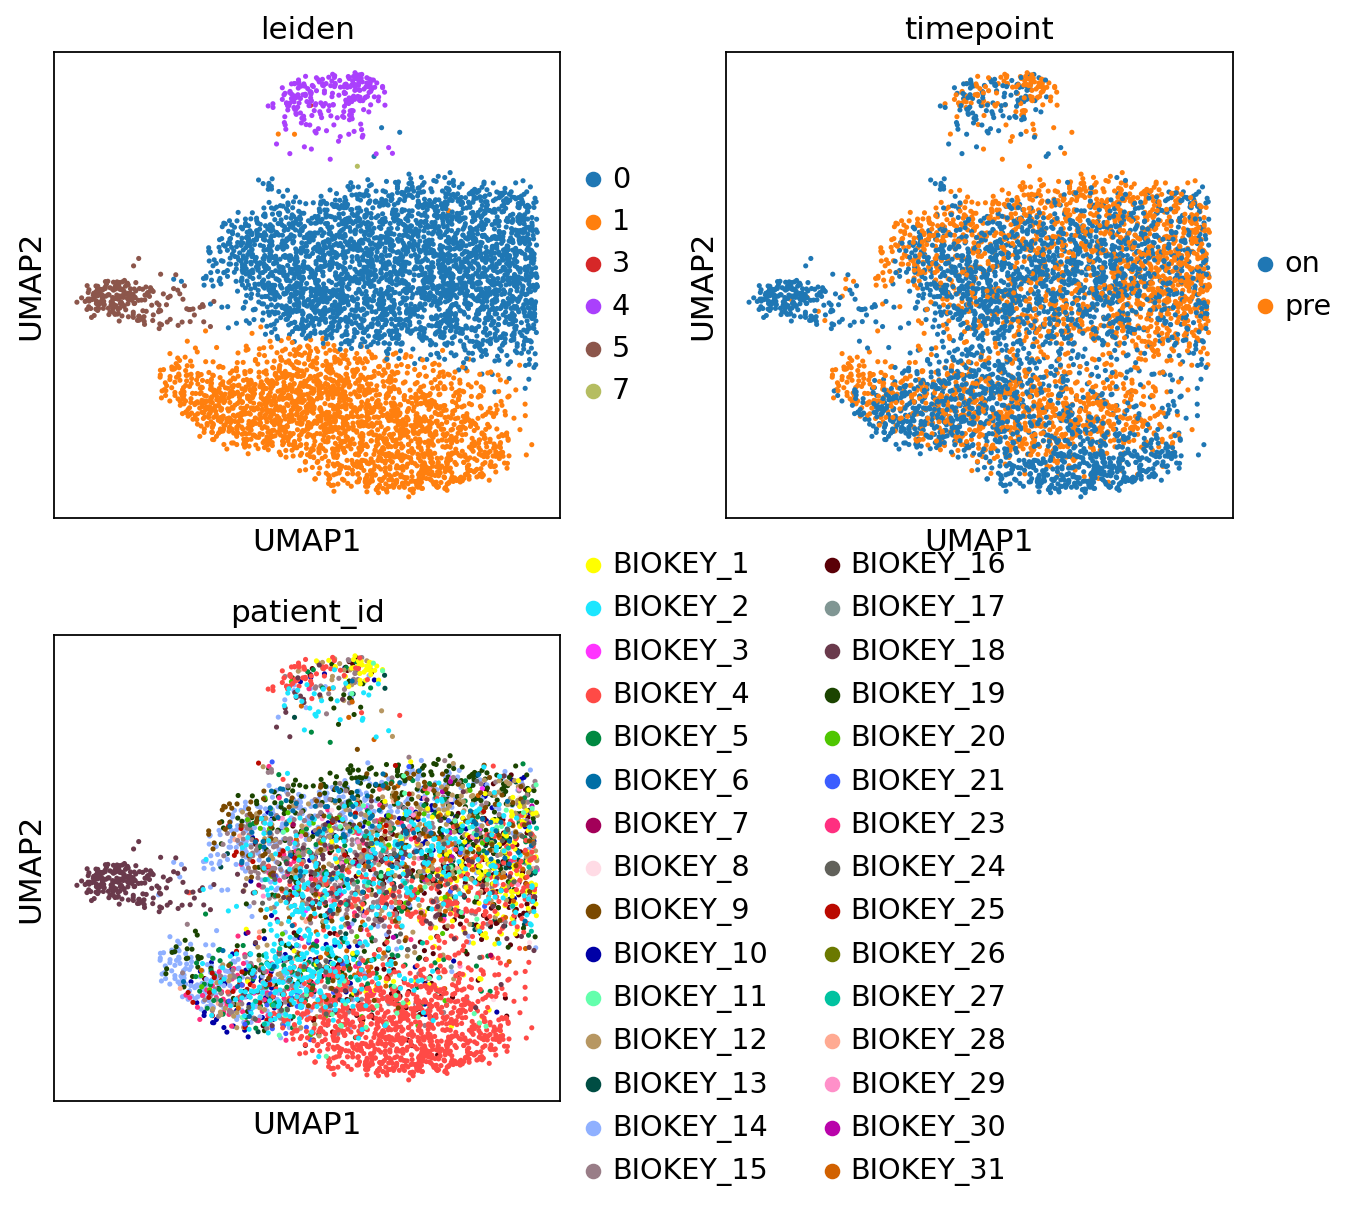

In [71]:
adata_B_clean = adata_B[(adata_B.obsm['X_umap'][:, 0] < 5.0), :].copy()
sc.pl.umap(adata_B_clean, color= ['leiden', 'timepoint', 'patient_id'], ncols= 2)

In [74]:
print(adata_B.shape)
print(adata_B_clean.shape)

(8982, 5000)
(5633, 5000)


## Extract epithelial cells and recluster

In [77]:
adata_Epi = adata[adata.obs['cell_type'] == 'Epithelial'].copy()
print(str(adata_Epi.shape))
# restore the X to original raw.X for re-processing 
adata_Epi  = ad.AnnData(X=adata_Epi.raw.X, obs=adata_Epi.obs, var=adata_Epi.raw.var, obsm=adata_Epi.obsm, uns=adata_Epi.uns)
# drop highly variable genes column from var dataframe
adata_Epi.var.drop(columns=['highly_variable'], inplace=True)
adata_Epi.raw = adata_Epi
adata_Epi.shape

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(29429, 10000)


(29429, 22956)

In [78]:
adata_Epi = clustering_adata(adata_Epi, n_top_genes = 5000)

Select  5000  high variance genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorica

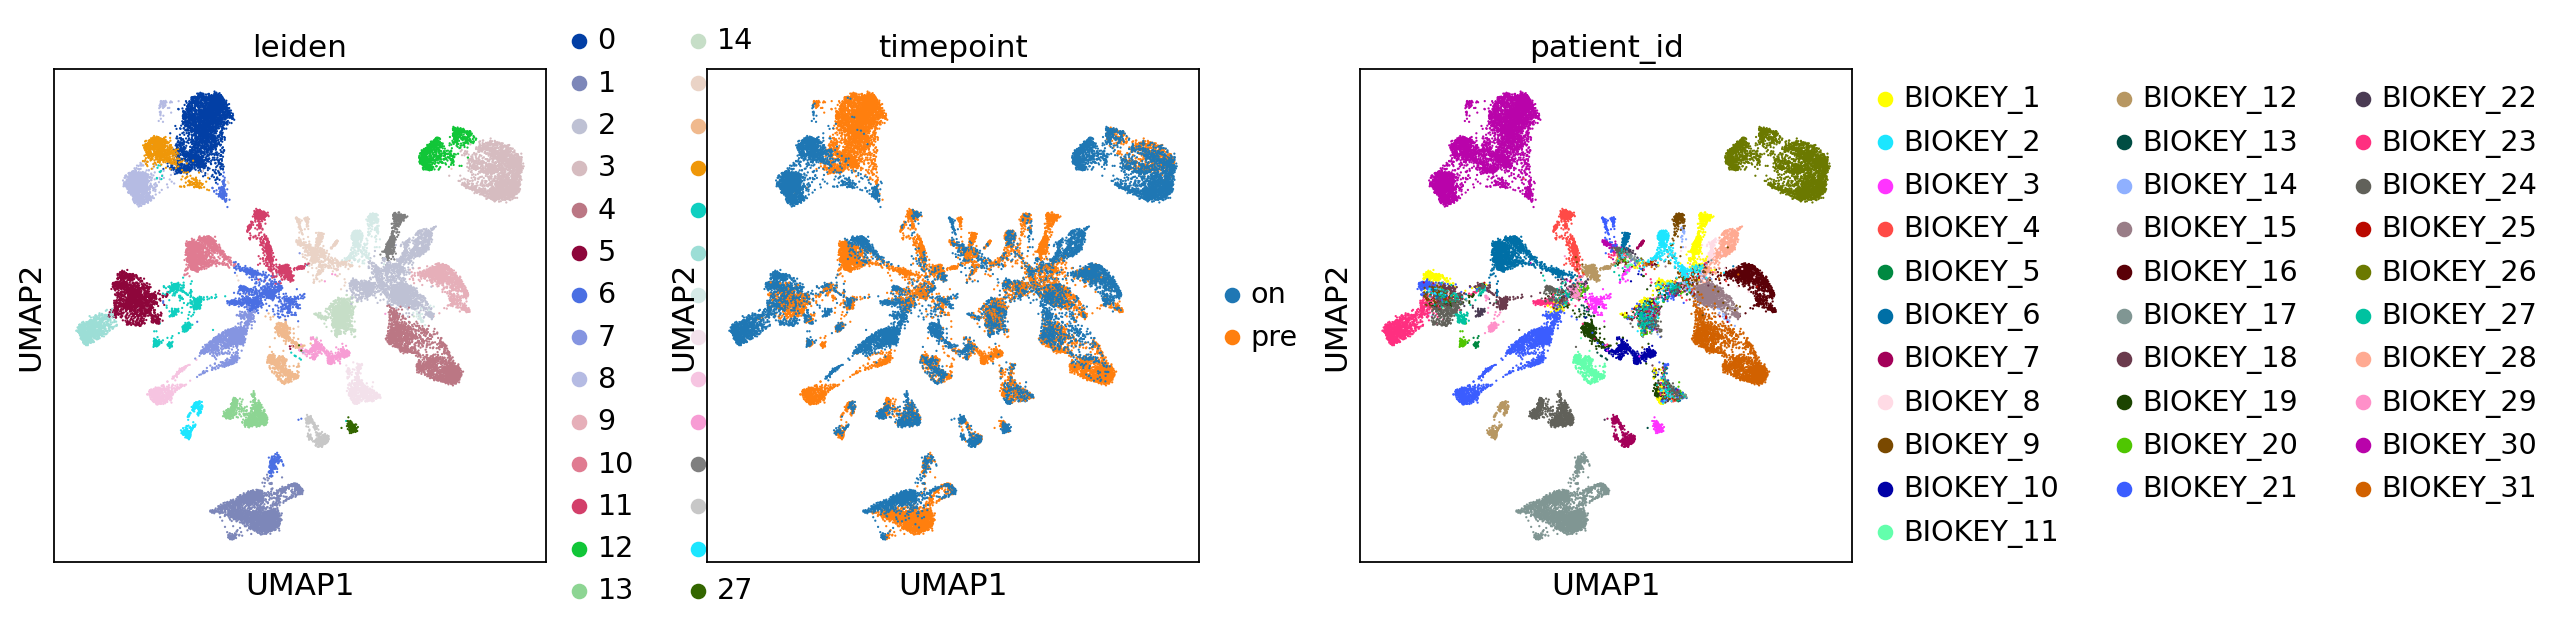

In [79]:
sc.pl.umap(adata_Epi, color=['leiden', 'timepoint', 'patient_id'])

In [81]:
adata_Epi.shape

(29429, 5000)

## Extract fibroblasts and recluster

In [83]:
adata_Fibro = adata[adata.obs['cell_type'] == 'Fibroblast'].copy()
print(str(adata_Fibro.shape))
# restore the X to original raw.X for re-processing
adata_Fibro  = ad.AnnData(X=adata_Fibro.raw.X, obs=adata_Fibro.obs, var=adata_Fibro.raw.var, obsm=adata_Fibro.obsm, uns=adata_Fibro.uns)
# drop the highly variable column from var
adata_Fibro.var.drop(columns=['highly_variable'], inplace=True)
adata_Fibro.raw = adata_Fibro
adata_Fibro.shape

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(22450, 10000)


(22450, 22956)

Select  5000  high variance genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorica

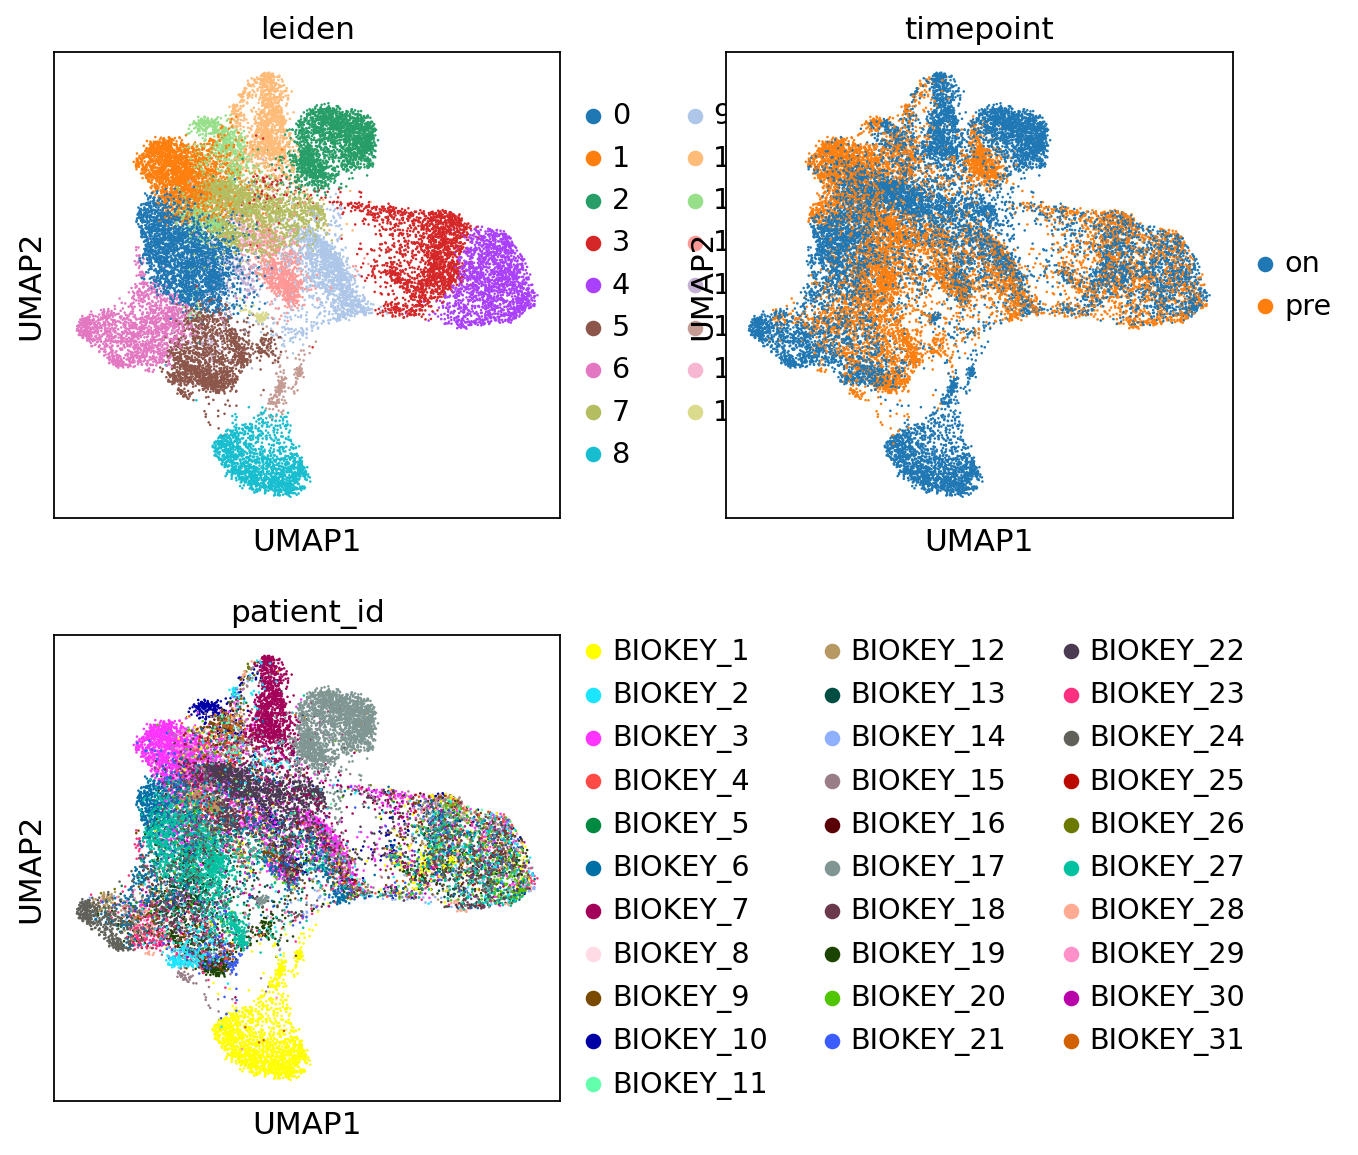

In [84]:
adata_Fibro = clustering_adata(adata_Fibro, resolution = 1.0, n_top_genes = 5000)
sc.pl.umap(adata_Fibro, color=['leiden', 'timepoint', 'patient_id'], ncols= 2)

## Extract Endothelial cells and reclustering

In [85]:
adata_Endo = adata[adata.obs['cell_type'] == 'Endothelial'].copy()
print(str(adata_Endo.shape))
# restore the X to original raw.X for re-processing
adata_Endo  = ad.AnnData(X=adata_Endo.raw.X, obs=adata_Endo.obs, var=adata_Endo.raw.var, obsm=adata_Endo.obsm, uns=adata_Endo.uns)
adata_Endo.raw = adata_Endo
adata_Endo.shape

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(5621, 10000)


(5621, 22956)

In [86]:
adata_Endo = clustering_adata(adata_Endo, n_top_genes = n_top_genes)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorica

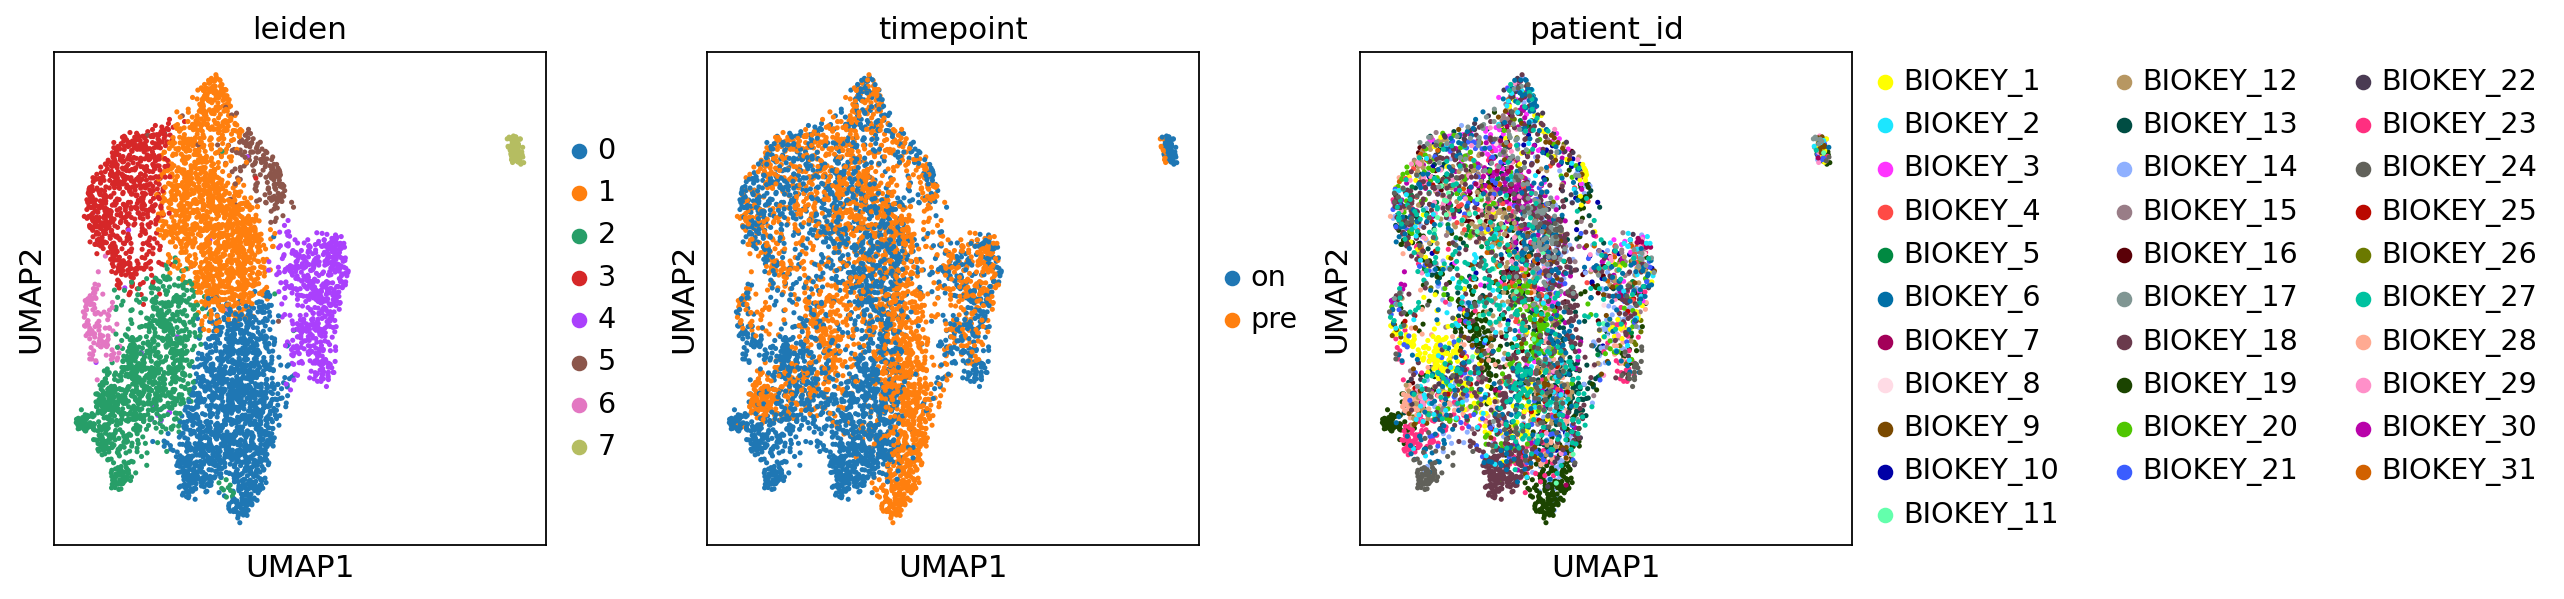

In [88]:
sc.pl.umap(adata_Endo, color=['leiden', 'timepoint', 'patient_id'])

## save all the data on my desktop

In [91]:
data_dir_NHDP = "/home/qiuaodon/Desktop/project_data/"
adata_B.write_h5ad(data_dir_NHDP + '1863-counts_cells_cohort1_B_cells.h5ad')
adata_Epi.write_h5ad(data_dir_NHDP + '1863-counts_cells_cohort1_Epi_cells.h5ad')
adata_Fibro.write_h5ad(data_dir_NHDP + '1863-counts_cells_cohort1_Fibro_cells.h5ad')
adata_Endo.write_h5ad(data_dir_NHDP + '1863-counts_cells_cohort1_Endo_cells.h5ad')
adata_T.write_h5ad(data_dir_NHDP + '1863-counts_cells_cohort1_T_cells.h5ad')
adata_M.write_h5ad(data_dir_NHDP + '1863-counts_cells_cohort1_M_cells.h5ad')